# The Sparse Mixture-of-Experts Layer



The [Sparse Mixture-of-Experts](https://arxiv.org/abs/1701.06538) (MoE) layer computes a **sparse** combination of expert modules (usually feed forward networks) for a given input.

In this notebook, we provide a walkthorugh for implementing a sparse MoE layer and then show how you can include it in a character-level language model.

This notebook is inspired by the makeMoE blog post, available at: https://huggingface.co/blog/AviSoori1x/makemoe-from-scratch.

*The following implementations are mearly illustrative and didactic, often at the cost of performance.*

## Part I: The Sparse MoE layer

The following picture illustrates the Sparse MoE layer where only one expert is selected.

![Sparse MoE layer](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhbsjq4iseHi-Azxcj0irBjGkma0yd4geSPPombnJSdd5dyzTguUU2pdFfZu4G38G4F4TiymUOaIkQnXGVAix5x8wF3-9Ov3NJwWaEZNvJY84CWCgU5MbUYI_DjKa_BvalTHu3eyfCJGR89UqwskKngsppDy94Gahz3HAoKLh2vmh-Jzb7ZedRI91OwFw/s960/image1.jpg)

> MoE layers combine the output of $n$ expert networks $\{E_1, \dots, E_n\}$ using a gating (or router) function $G$. The following equation defines an MoE layer. It maps an input vector $x$ to a weighted sum of the experts' outputs, where the gating function assigns the weights.
>
> $$
> y = \sum_{i=1}^{n} G(x)_i E_i(x)
> $$
>
> Sparse MoE layers rely on **sparse gating functions**, which only select a subset of experts. This can be achieved with a sparse gating vector *i.e.*, by assigning some experts 0 weight. Importantly, the *computation for experts assigned zero weight can be skipped*.

At the core of the sparse MoE layer is its sparse gating (or routing) function, which assigns a weight to each expert.

> The sparse gating function $G : \mathbb{R}^N → \mathbb{R}^E$ maps an input token to a sparse vector with the weight scores of each expert.

A common approach is to learn a linear transformation $W_g^{N \times E}$ which maps the input token representations to affinity scores for each expert and then select the highest k:

$$
G(x) = Softmax(KeepTopK(W_g x, k)), \text{where} \\
KeepTopK(z, k)_i =
\begin{cases}
  z_i & \text{if $z_i$ in the top $k$ elements of $z$} \\
  -\inf & \text{otherwise}
\end{cases}
$$

In [ ]:
import torch
import torch.nn as nn

def topk_scores(gate: nn.Linear, k: int, x: torch.Tensor):
    raw_scores = gate(x)
    scores = keep_topk(raw_scores, k)
    scores = torch.softmax(scores, dim=-1, dtype=torch.float32)
    return scores

def keep_topk(scores: torch.Tensor, k: int) -> torch.Tensor:
    _, topk_indices = scores.topk(k, dim=-1)
    assignment = torch.zeros_like(scores, dtype=torch.bool)
    assignment.scatter_(-1, topk_indices, True)
    return torch.where(assignment, scores, float("-inf"))

Another component of sparse MoE layers are the experts.

> An expert $E : \mathbb{R}^N → \mathbb{R}^N$ learns a (usually) non-linear transformation of the input x.

In this notebook, we will use a two-layer MLP.

In [ ]:
def make_expert(hidden_size, ffn_hidden_size = None):
  if ffn_hidden_size is None:
    ffn_hidden_size = 4 * hidden_size
  return nn.Sequential(
      nn.Linear(hidden_size, ffn_hidden_size),
      nn.GELU(),
      nn.Linear(ffn_hidden_size, hidden_size),
  )

One important aspect of constructing the experts is ensuring that they only compute the output representations for selected inputs.

In [ ]:
def run_expert(expert: nn.Module, expert_scores: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    # Select the inputs to compute and totally skip the expert if it was not selected.
    selected_x = x[expert_scores > 0]
    if len(selected_x) == 0:
        return None

    weights = expert_scores[expert_scores > 0].unsqueeze(-1)

    return weights * expert(selected_x)

One final component of top-k routing is load balancing. One common way of implementing it is:

$$
L_{LB} = n \sum_{i=1}^n f_i \cdot P_i \text{, where}
$$

$f_i$ represents the fraction of tokens routed to expert $i$ and P_i is the average probability over all tokens assigned to expert i.

Note that the probabilities are before the gating function.

In [ ]:
def load_balancing_loss(
    raw_scores: torch.Tensor, token_assignment: torch.Tensor,
) -> torch.Tensor:
    _, num_experts = raw_scores.size()
    raw_scores = torch.softmax(raw_scores, dim=-1, dtype=torch.float32)

    # Compute the fraction of tokens assigned to each expert.
    token_fractions = einops.reduce(token_assignment.float(), "t e -> e", "mean")

    # Compute the average weight of each expert.
    average_weights = einops.reduce(raw_scores, "t e -> e", "mean")
    return num_experts ** 2 * (token_fractions * average_weights).mean()

We can now update the `keep_topk` function to include load balancing and save it to a global variable with a losses.

In [ ]:
def keep_topk(scores: torch.Tensor, k: int) -> torch.Tensor:
  _, topk_indices = scores.topk(k, dim=-1)
  assignment = torch.zeros_like(scores, dtype=torch.bool)
  assignment.scatter_(-1, topk_indices, True)
  append_lb_loss(load_balancing_loss(scores, assignment))
  return torch.where(assignment, scores, float("-inf"))

_lb_losses = []

def append_lb_loss(loss: torch.Tensor) -> None:
  global _lb_losses
  assert (loss >= 0.0).all(), f"Negative loss: {loss.item()}"
  _lb_losses.append(loss)

def get_lb_losses() -> list[torch.Tensor]:
  global _lb_losses
  return _lb_losses

def clear_lb_losses() -> None:
  global _lb_losses
  _lb_losses = []

Putting everything together, we can run a sparse MoE layer by first obtaining the scores and then computing the expert outputs for the selected tokens.

In [ ]:
class MoELayer(nn.Module):
  def __init__(
      self,
      *,
      hidden_size: int,
      num_experts: int,
      k: int,
      idx: int,
      ffn_hidden_size = None,
  ):
    super().__init__()
    self.gate = nn.Linear(hidden_size, num_experts)
    self.experts = nn.ModuleList(
        [make_expert(hidden_size, ffn_hidden_size) for _ in range(num_experts)]
    )
    self.k = k
    self.idx = idx

  def forward(self, x: torch.Tensor):
    # Flatten all dimensions (e.g batch, seq len)
    x_flat = x.view(-1, x.size(-1))

    scores = topk_scores(self.gate, self.k, x_flat)

    outputs = torch.zeros_like(x_flat)
    for i, expert in enumerate(self.experts):
      expert_scores = scores[:, i]

      expert_outputs = run_expert(expert, expert_scores, x_flat)
      if expert_outputs is None:
        continue

      outputs[expert_scores > 0] += expert_outputs

    # Recover original dimensions
    outputs = outputs.view_as(x)

    return outputs

## Part II: The training data

With the sparse MoE layer implemented, we will move towards developing a character level model using that layer. The model will be trained on text from Shakespeare, available at [https://raw.githubusercontent.com/AviSoori1x/makeMoE/main/input.txt
](https://raw.githubusercontent.com/AviSoori1x/makeMoE/main/input.txt
).

We will start by downloading and inspecting the data.

In [ ]:
# Downloading the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/AviSoori1x/makeMoE/main/input.txt

# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("Length in characters: ", len(text))

# let's look at the first 100 characters
print("First 100 characters", "-" * 50)
print(text[:100])

--2024-11-07 21:31:10--  https://raw.githubusercontent.com/AviSoori1x/makeMoE/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.6’

input.txt.6         100%[===================>]   1.06M  --.-KB/s    in 0.009s  

2024-11-07 21:31:10 (119 MB/s) - ‘input.txt.6’ saved [1115394/1115394]

Length in characters:  1115394
First 100 characters --------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


From here, we can create the model vocabulary, which maps the characters into token ids.

In [ ]:
class Vocabulary:

  def __init__(self, text: str):
    chars = set(text)
    self.ctoi = {c: i for i, c in enumerate(chars)}
    self.itoc = {v: k for k, v in self.ctoi.items()}

  def encode(self, text: str) -> list[int]:
    return [self.ctoi[t] for t in text]

  def decode(self, ids: list[int]) -> str:
    return "".join(self.itoc[i] for i in ids)

  def __len__(self):
    return len(self.ctoi)

  def __str__(self):
    return f"Vocabulary[size={len(self)}]{self.ctoi}"

We can train the vocabulary on the whole training set and some light testing to check that everything is working as expected.

In [ ]:
vocab = Vocabulary(text)
print(vocab)

# Test if encoding/decoding work
first_chars = text[:1000]
encoded = vocab.encode(first_chars)
decoded = vocab.decode(encoded)
assert first_chars == decoded

Vocabulary[size=65]{'u': 0, ';': 1, '-': 2, 'z': 3, 'Z': 4, 'Q': 5, 'B': 6, 'V': 7, "'": 8, 'E': 9, 'P': 10, 'W': 11, 'U': 12, 'i': 13, '3': 14, 'F': 15, 'j': 16, 'e': 17, 'A': 18, 'K': 19, 'v': 20, 'p': 21, 'o': 22, 'L': 23, 'd': 24, 'X': 25, 'y': 26, '?': 27, ' ': 28, 'f': 29, 'D': 30, ':': 31, 'C': 32, 'c': 33, 'G': 34, 'g': 35, '\n': 36, 'm': 37, 'k': 38, '!': 39, 'w': 40, 'n': 41, 'l': 42, 'J': 43, 'M': 44, 'N': 45, '$': 46, 'a': 47, 'b': 48, 'O': 49, 'x': 50, 's': 51, '&': 52, 'r': 53, 't': 54, 'S': 55, 'I': 56, 'Y': 57, 'H': 58, '.': 59, 'T': 60, 'R': 61, 'h': 62, 'q': 63, ',': 64}


Afterwards, we can encode the data as a tensor and create a train and validation split.

In [ ]:
# Encode all text
encoded_text = torch.tensor(vocab.encode(text))
print("Total tokens:", encoded_text.size(0))
# Split into train and validation
val_size = 2000

encoded_train = encoded_text[:-val_size]
encoded_val = encoded_text[-val_size:]
print("Train tokens:", encoded_train.size(0))
print("Val tokens: ", encoded_val.size(0))

Total tokens: 1115394
Train tokens: 1113394
Val tokens:  2000


From here, we can create the dataset class to iterate the data. Each record will be a chunk of adjacent tokens and the model will learn to predict the next token from the previous ones.

In [ ]:
import torch.utils.data

# Predict on block_size contiguous tokens
seq_len = 64


class ShakespeareDataset(torch.utils.data.Dataset):

  def __init__(self, data: torch.Tensor, seq_len: int):
    self.data = data
    self.seq_len = seq_len


  def __getitem__(self, i: int) -> torch.Tensor:
    # Account for extra one in LM offset
    data = self.data[i:i + self.seq_len + 1]
    x = data[:-1]
    y = data[1:]
    return x, y

  def __len__(self):
    return len(self.data) - self.seq_len - 1

train = ShakespeareDataset(encoded_train, seq_len)
val = ShakespeareDataset(encoded_val, seq_len)
print("Train size:", len(train), ", val size:", len(val))

Train size: 1113329 , val size: 1935


## Part III: The MoE Transformer Model

Finally, we can create the transformer model with the sparse MoE layer replacing the usual feed forward network.

![Transformer architecture](https://www.researchgate.net/publication/373183262/figure/fig2/AS:11431281182174638@1692321759226/Decoder-only-Transformer-architecture-The-input-to-the-decoder-is-tokenized-text-and.png)

We start by defining the model configuration.

*This network implementation is mearly illustrative.*

In [ ]:
import dataclasses

@dataclasses.dataclass
class Config:
  seq_len: int = seq_len
  n_layers: int = 4
  n_heads: int = 4
  hidden_size: int = 128
  ffn_hidden_size: int = 256
  head_size: int = 32
  vocab_size: int = len(vocab)

  k: int = 4
  normalize_scores: int = True
  n_experts: int = 16

Afterwards, we define the self-attention mechanism.

In [ ]:
import einops
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):

  def __init__(self, config: Config):
    super().__init__()
    self.config = config
    # We have n_head projections, each projecting to head_dim for the queries, keys and values.
    self.queries_proj = nn.Linear(config.hidden_size, config.n_heads * config.head_size)
    self.keys_proj = nn.Linear(config.hidden_size, config.n_heads * config.head_size)
    self.values_proj = nn.Linear(config.hidden_size, config.n_heads * config.head_size)
    self.out_proj = nn.Linear(config.n_heads * config.head_size, config.hidden_size)

  def forward(self, x: torch.Tensor, is_causal: bool = True, use_sdpa: bool = True):
    _, T, _ = x.size()
    n_heads, head_dim = self.config.n_heads, self.config.head_size

    # Compute projections and split by queries, keys and values.
    q, k, v = self.queries_proj(x), self.keys_proj(x), self.values_proj(x)

    if use_sdpa:
      q = einops.rearrange(q, "b t (head proj) -> b head t proj", head=n_heads, proj=head_dim)
      k = einops.rearrange(k, "b t (head proj) -> b head t proj", head=n_heads, proj=head_dim)
      v = einops.rearrange(v, "b t (head proj) -> b head t proj", head=n_heads, proj=head_dim)

      out = F.scaled_dot_product_attention(q, k, v, dropout_p=0.0, is_causal=is_causal)
    else:
      q = einops.rearrange(q, "b t (head proj) -> b t head proj", head=n_heads, proj=head_dim)
      k = einops.rearrange(k, "b t (head proj) -> b t head proj", head=n_heads, proj=head_dim)
      v = einops.rearrange(v, "b t (head proj) -> b t head proj", head=n_heads, proj=head_dim)

      # Compute unnormalized attention scores
      a = einops.einsum(q, k, "b query head proj, b key head proj -> b head query key") # (b, n_heads, T, T)
      a = a / head_dim ** 0.5 # (b, n_heads, T, T)
      # Mask future tokens
      if is_causal:
        mask = torch.tril(torch.ones((T, T), dtype=torch.bool, device=x.device))
        a = torch.masked_fill(a, mask == 0, float("-inf")) # (b, n_heads, T, T)
      # Compute attention weights
      a = torch.softmax(a, dim=-1) # (b, n_heads, T, T)

      # Compute attention values
      out = einops.einsum(a, v, "b head query key, batch key head proj -> b head query proj")

    # Reorder to have all head values for token together
    out = einops.rearrange(out, "b head time proj -> b time (head proj)")

    # Compute the final projection
    out = self.out_proj(out)
    return out

config = Config()
attn = MultiHeadAttention(config)
input = torch.rand(4, 8, config.hidden_size)
out = attn(input, is_causal=True)
out.size()

torch.Size([4, 8, 128])

Finally, we define the block module and the full transformer.

For this example, we use learnt embeddings to represent positional information in the transformer.

In [ ]:
class Block(nn.Module):

  def __init__(self, config: Config, idx: int):
    super().__init__()
    self.attn = MultiHeadAttention(config)
    self.attn_norm = nn.LayerNorm(config.hidden_size)
    self.mlp = MoELayer(
        hidden_size=config.hidden_size,
        num_experts=config.n_experts,
        k=config.k,
        idx=idx,
        ffn_hidden_size=config.ffn_hidden_size,
    )
    self.mlp_norm = nn.LayerNorm(config.hidden_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    h = self.attn_norm(x)
    h = self.attn(h, use_sdpa=True)
    x = x + h
    h = self.mlp_norm(x)
    h = self.mlp(h)
    x = x + h
    return x


class Transformer(nn.Module):

  def __init__(self, config: Config):
    super().__init__()
    self.tok_emb = nn.Embedding(config.vocab_size, config.hidden_size)
    self.pos_emb = nn.Embedding(config.seq_len, config.hidden_size)
    self.blocks = nn.ModuleList(Block(config, i) for i in range(config.n_layers))
    self.final_norm = nn.LayerNorm(config.hidden_size)
    self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

  def forward(self, tokens: torch.Tensor) -> torch.Tensor:
    tok_emb = self.tok_emb(tokens)
    pos_emb = self._get_pos_embeddings(tokens)

    hidden_states = tok_emb + pos_emb

    for block in self.blocks:
      hidden_states = block(hidden_states)

    hidden_states = self.final_norm(hidden_states)
    logits = self.lm_head(hidden_states)
    return logits

  def _get_pos_embeddings(self, tokens: torch.Tensor) -> torch.Tensor:
    batch_size, seq_len = tokens.size()
    pos_idx = torch.arange(seq_len, device=tokens.device)
    pos_emb = self.pos_emb(pos_idx)
    return pos_emb


## Part IV: Training and Evaluation

In [ ]:
def forward(
    *,
    model: Transformer,
    lb_loss_scale: float,
    device_type: str,
    x: torch.Tensor,
    y: torch.Tensor,
):
  # Runs the model in mixed precision, which improves overall speed
  # with minimal performance degradation.
  # https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training
  with torch.autocast(device_type=device_type, dtype=torch.float16):
    logits = model(x)
    logits = einops.rearrange(logits, "b s e -> (b s) e")
    y = einops.rearrange(y, "b s -> (b s)")
    ce_loss = F.cross_entropy(logits, y)
    lb_loss = torch.tensor(0.0, device=ce_loss.device)
    for l in get_lb_losses():
      lb_loss += l
    lb_loss = lb_loss_scale * lb_loss
    loss = ce_loss + lb_loss
    clear_lb_losses()

  return loss, ce_loss.item(), lb_loss.item()

In [ ]:
def train_step(
    *,
    model: Transformer,
    optimizer: torch.optim.Optimizer,
    scaler,
    lb_loss_scale: float,
    device_type: str,
    x: torch.Tensor,
    y: torch.Tensor,
):
  loss, ce_loss, lb_loss = forward(
    model=model,
    lb_loss_scale=lb_loss_scale,
    device_type=device_type,
    x=x,
    y=y)

  scaler.scale(loss).backward()

  scaler.step(optimizer)

  scaler.update()

  optimizer.zero_grad(set_to_none=True)

  return loss.item(), ce_loss, lb_loss

In [ ]:
@torch.no_grad
def validate(
    *,
    model: Transformer,
    val_dataloader: torch.utils.data.DataLoader,
    lb_loss_scale: float,
    device_type: str,
):
    model.eval()
    total_loss = 0.0
    total_ce_loss = 0.0
    total_lb_loss = 0.0
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        loss, ce_loss, lb_loss = forward(
            model=model,
            lb_loss_scale=lb_loss_scale,
            device_type=device_type,
            x=x,
            y=y)
        total_loss += loss.item()
        total_ce_loss += ce_loss
        total_lb_loss += lb_loss
    total_loss /= len(val_dataloader)
    total_ce_loss /= len(val_dataloader)
    total_lb_loss /= len(val_dataloader)
    clear_lb_losses()
    model.train()
    return total_loss, total_ce_loss, total_lb_loss

In [ ]:
@torch.no_grad
def generate(
  model: nn.Module,
  vocab: Vocabulary,
  input: str,
  new_tokens: int,
  device_type,
):
  model.eval()
  idx = vocab.encode(input)
  idx = torch.tensor(idx, dtype=torch.long, device=device)
  idx = einops.rearrange(idx, "... -> 1 ...")

  for t in range(new_tokens):
    # The model only considers the previous seq len characters.
    ctx = idx[:, -seq_len:]

    with torch.autocast(device_type=device_type, dtype=torch.float16):
      logits = model(ctx)

    next_logits = logits[:, -1, :]

    next_probs = torch.softmax(next_logits, dim=-1)

    next_idx = torch.multinomial(next_probs, num_samples=1)
    # append sampled index to the running sequence and continue
    idx = torch.cat((idx, next_idx), dim=1)

  idx = idx.tolist()[0]
  output = vocab.decode(idx)
  clear_lb_losses()
  model.train()
  return output

In [ ]:
import functools
import random
import torch
import torch.cuda

import torch.optim
import time

from typing import Literal

random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision("high")


device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
  print("WARNING: Using cpu device, training will be slow")

train_dataloader = torch.utils.data.DataLoader(
    train, batch_size=64, shuffle=True, pin_memory=True, num_workers=2, prefetch_factor=2,
)
val_dataloader = torch.utils.data.DataLoader(
    val, batch_size=64, shuffle=False, pin_memory=True, num_workers=2, prefetch_factor=2,
)

config = Config()
model = Transformer(config)
lb_loss_scale = 0.01

model_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {model_params / 1e6:.2f}M")

optimizer = torch.optim.AdamW(
    model.parameters(), lr=2e-3, weight_decay=0.1, betas=(0.9, 0.95),
)
scaler = torch.amp.GradScaler()
model.to(device)

num_steps = 2500
val_every = 250
dataiter = iter(train_dataloader)
start_time = time.time()
start_step = time.time()
val_input = "\n" # Simulate the end of the last paragraph
val_gen_tokens = 200

train_losses = []
val_losses = []

def run_validation():
  val_loss, val_ce_loss, val_lb_loss = validate(
      model=model,
      val_dataloader=val_dataloader,
      lb_loss_scale=lb_loss_scale,
      device_type=device,
  )
  print("Validation", "-" * 40)
  print("Total loss:", val_loss)
  print("CE loss:", val_ce_loss)
  print("LB loss:", val_lb_loss)
  output = generate(
      model,
      vocab,
      val_input,
      val_gen_tokens,
      device
  )
  print("Output", "-" * 30)
  print(output[1:])
  print("-" * 50)
  return val_loss, val_ce_loss, val_lb_loss

val_losses.append(run_validation())

for step in range(1, num_steps + 1):
  x, y = next(dataiter)
  x, y = x.to(device), y.to(device)
  token_count = x.numel()
  loss, ce_loss, lb_loss = train_step(
      model=model,
      optimizer=optimizer,
      scaler=scaler,
      lb_loss_scale=lb_loss_scale,
      device_type=device,
      x=x,
      y=y)
  train_losses.append((loss, ce_loss, lb_loss))
  step_time = time.time() - start_step
  start_step = time.time()
  if step % 10 == 0:
    completed = step / num_steps * 100
    ellapsed = time.time() - start_time
    tok_per_sec = token_count / step_time
    fmt_ellapsed = time.strftime("%H:%M:%S", time.gmtime(ellapsed))
    print(
        f"Step {step}/{num_steps} ({completed:.0f}%): "
        f"TrainTime={fmt_ellapsed}, "
        f"Loss={loss:.4f}, "
        f"TokensPerSec={tok_per_sec:.0f}, "
        f"StepTime={step_time:.2}s"
    )
  if step % val_every == 0:
    val_losses.append(run_validation())

Total parameters: 4.52M
Validation ----------------------------------------
Total loss: 4.471826907127134
CE loss: 4.3057933622790925
LB loss: 0.1660335539810119
Output ------------------------------
lAE.;PJWM&
w,j QF&CZ-VHQ.mrcllED!WxSCccB mPqeOoB.-3JkjLscerVZm:EhLxEt?RaEFwXpLpC zOSINOJt witmUo'gKpnreqWBJLJlXTqDlz xpOvsZnyeqAaObXtYpwZ$ OmZsc!tjvAX.ISkb?XANtYvAh mPnBSWOVvlFXJby lAaJCRVTQwR.?re$TnJ
--------------------------------------------------
Step 10/2500 (0%): TrainTime=00:00:11, Loss=3.0564, TokensPerSec=25492, StepTime=0.16s
Step 20/2500 (1%): TrainTime=00:00:13, Loss=2.7540, TokensPerSec=18587, StepTime=0.22s
Step 30/2500 (1%): TrainTime=00:00:15, Loss=2.7276, TokensPerSec=29404, StepTime=0.14s
Step 40/2500 (2%): TrainTime=00:00:16, Loss=2.6466, TokensPerSec=24925, StepTime=0.16s
Step 50/2500 (2%): TrainTime=00:00:18, Loss=2.6029, TokensPerSec=26793, StepTime=0.15s
Step 60/2500 (2%): TrainTime=00:00:19, Loss=2.5858, TokensPerSec=29737, StepTime=0.14s
Step 70/2500 (3%): TrainTi

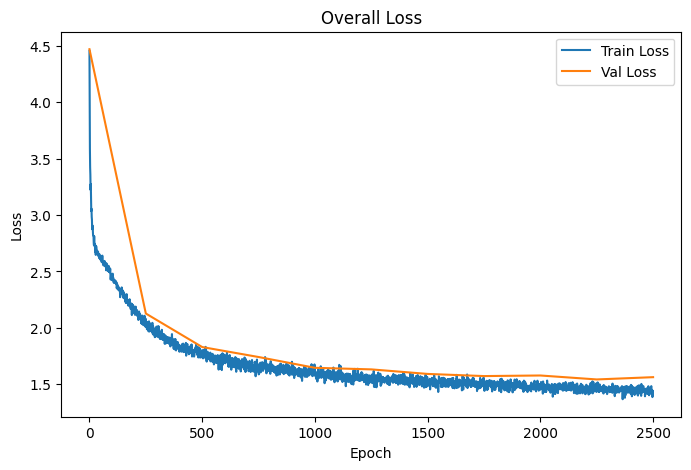

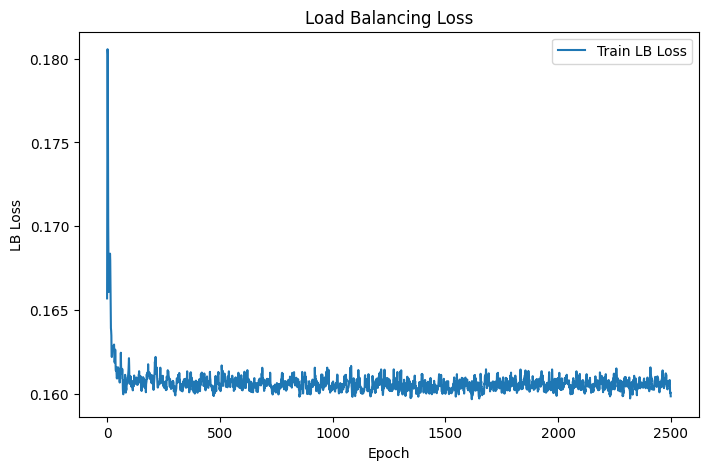

In [ ]:
import matplotlib.pyplot as plt

# Create x-axis values for training and validation losses
train_steps = list(range(len(train_losses)))  # Assuming 1 step per training loss
val_steps = [i * val_every for i in range(len(val_losses))]  # Validation steps every 100 steps

# Extract the losses
train_loss, train_ce_loss, train_lb_loss = zip(*train_losses)
val_loss, val_ce_loss, val_lb_loss = zip(*val_losses)


# Plot overall loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, label='Train Loss')
plt.plot(val_steps, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overall Loss')
plt.legend()
plt.show()

# Plot load balancing loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_lb_loss, label='Train LB Loss')
plt.xlabel('Epoch')
plt.ylabel('LB Loss')
plt.title('Load Balancing Loss')
plt.legend()
plt.show()

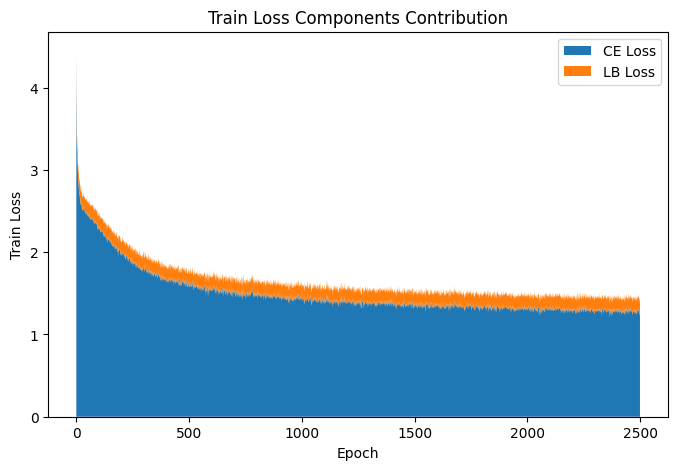

In [ ]:
# Plot stacked area plot for train losses
plt.figure(figsize=(8, 5))
plt.stackplot(train_steps, train_ce_loss, train_lb_loss, labels=['CE Loss', 'LB Loss'])
#plt.plot(train_steps, train_loss, label='Total Loss', color='black', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss Components Contribution')
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_input = "\n" # Continue to use new line as if beginning a new paragraph
test_gen_len = 1000
test_output = generate(
    model,
    vocab,
    test_input,
    test_gen_len,
    device
)

print(test_output)


MUCIO:
Why, not marriage; I am as a horse,
But from Edward, into the body to the every 'gainst thing;
Here be still thy wrongs being with what
oppose thine eiver had we confess and pursors.

TRANIO:
And sound, 'tis brief, well home to enters,
Even the inclinenes your abster 'lame.

AEdile:
Thy maid is offence to his pitience!

SICINIUS:
I have a thing eaten could.

CURTIS:
Shall my love?

LEONTES:
Say you confessess'd the ill.

KING EDWARD IV:
I thence, my lord; and I thank you, quickly love.

KING RICHARD III:
I thank upon your brands: if you may, tell you
The air ire is easy pride to among me to you;
Honsome this souls and was at life, you help
Till you shall bring it coast I have done.
Ay, back?

HENRY PERCY:
Comingham, neise, my lord; what offender of hands Boots
Be cooked against a lion again.

LADY ANNE:
Kind that said Hereford's recongeas;
We, in the bragge of the garden and worth i slain
As thou art is at BlashSativel, and
see it so strucking but in Capulet can
Thomas much wit